# Hippocampus Neurogenesis Toy Model

In [1]:
from ipywidgets import widgets, FloatSlider
from IPython.display import display
import numpy as np
import scipy as sp
import scipy.integrate

import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn
seaborn.set_context('notebook')

## Some helper functions:

In [2]:
def rloss(p):
    r1loss = p['r111'] - p['r122'] - p['r12']
    r2loss = p['r222'] + p['N1tot'] / p['N2tot'] * (2 * p['r122'] + p['r112'] + p['r12'])
#     print(r2loss)
    return r1loss, r2loss

def set_color(p):
    if sp.any(sp.array(rloss(p)) < 0.0):
        color = 'red'
    else:
        color = 'black'
    return color

def title(p):
    return dict(t= 'r1loss = {0:.1f}, r2loss = {1:.1f}'.format(*rloss(p)),
                color = set_color(p))

def update_plot_cell_numbers(widgets_list):
    for widget in widgets_list:
        p[widget.description] = widget.value

    t, u1, u2, l1, l2 = solve_ode(p)
    
    fig.suptitle(**title(p))
    
    lNtot1[0].set_data(t, u1 + l1)
    lNtot2[0].set_data(t, u2 + l2)
    lratio1[0].set_data(t, l1 / (u1 + l1))
    lratio2[0].set_data(t, l2 / (u2 + l2))
    lN1[0].set_data(t, u1)
    lN2[0].set_data(t, u2)
    ll1[0].set_data(t, l1)
    ll2[0].set_data(t, l2)
    
    ax[1,1].set_xlim(p['t_min'], p['t_max'])
    for cax in [ax[0, 0], ax[1, 0], ax[1, 1]]:
        cax.set_ylim(0, 1.1 * max(p['N1tot'], p['N2tot']))

## Defining the model

In [3]:
def func(y, t0, p):
    r1loss, r2loss = rloss(p)
    
    dy0dt = (p['r111'] - p['r122'] - p['r12'] - r1loss) * y[0]
    dy1dt = (2 * p['r122'] + p['r112'] + p['r12']) * y[0] + (p['r222'] - r2loss) * y[1]
    return sp.array([dy0dt, dy1dt])

In [4]:
def solve_ode(p):
    t = sp.linspace(p['t_min'], p['t_max'], 100)
    
    N0 = sp.array([p['N1tot'], p['N2tot']])
    f = sp.array([p['f1'], p['f2']])
    u0 = (1.0 - f) * N0
    l0 = f * N0
    
    u = sp.integrate.odeint(func, u0, t, args = (p,))
    u1, u2 = u[:,0], u[:,1]
    l = sp.integrate.odeint(func, l0, t, args = (p,))
    l1, l2 = l[:,0], l[:,1]
    return t, u1, u2, l1, l2

## Model Parameters

In [5]:
p = dict(N1tot = 1000.0,
         N2tot = 2000.0,
         
         r111 = 1.0,
         r112 = 0.0,
         r122 = 0.3,
         
         r12 = 0.0,
         
         r222 = 0.0,
         
         f1 = 0.4,
         f2 = 0.1,

         t_min = 0.0,
         t_max = 10.0,
         
        )

## Create widgets and group them in a box

In [6]:
#create widgets
widgets_list =  [FloatSlider(p['N1tot'], min = 100.0, max = 10000.0, step = 100.0, description = 'N1tot'),
            FloatSlider(p['N2tot'], min = 100.0, max = 10000.0, step = 100.0, description = 'N2tot'), 
            FloatSlider(p['r111'], min = 0.0, max = 1.0, step = 0.1, description = 'r111'), 
            FloatSlider(p['r112'], min = 0.0, max = 1.0, step = 0.1, description = 'r112'), 
            FloatSlider(p['r122'], min = 0.0, max = 1.0, step = 0.1, description = 'r122'), 
            FloatSlider(p['r12'], min = 0.0, max = 1.0, step = 0.1, description = 'r12'), 
            FloatSlider(p['r222'], min = 0.0, max = 1.0, step = 0.1, description = 'r222'), 
            FloatSlider(p['f1'], min = 0.0, max = 1.0, step = 0.1, description = 'f1'), 
            FloatSlider(p['f2'], min = 0.0, max = 1.0, step = 0.1, description = 'f2'), 
            FloatSlider(p['t_max'], min = 0.1, max = 20.0, step = 0.1, description = 't_max')]

# link the widgets with the function
for widget in widgets_list:
    widget.observe(lambda change:update_plot_cell_numbers(widgets_list))
    
# group the widgets into a FlexBox
w = widgets.VBox(children=widgets_list)

## Plotting the model prediction

In [7]:
t, u1, u2, l1, l2 = solve_ode(p)

<IPython.core.display.Javascript object>


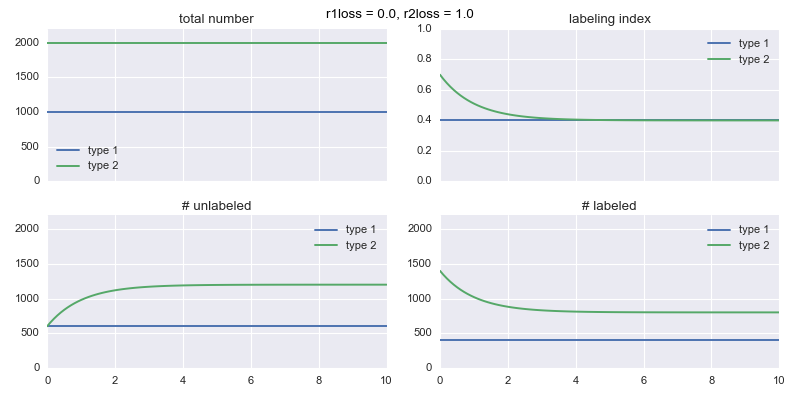

In [8]:
fig, ax = plt.subplots(2, 2, figsize = (10,5), sharex = True)

fig.suptitle(**title(p))

lNtot1 = ax[0, 0].plot(t, u1 + l1, label = 'type 1')
lNtot2 = ax[0, 0].plot(t, u2 + l2, label = 'type 2')

ax[0, 0].legend(loc = 'best')
ax[0, 0].set_title('total number')

lratio1 = ax[0, 1].plot(t, l1 / (u1 + l1), label = 'type 1')
lratio2 = ax[0, 1].plot(t, l2 / (u2 + l2), label = 'type 2')

ax[0, 1].legend()
ax[0, 1].set_title('labeling index')
ax[0, 1].set_ylim(0, 1)

lN1 = ax[1, 0].plot(t, u1, label = 'type 1')
lN2 = ax[1, 0].plot(t, u2, label = 'type 2')

ax[1, 0].legend()
ax[1, 0].set_title('# unlabeled')

ll1 = ax[1, 1].plot(t, l1, label = 'type 1')
ll2 = ax[1, 1].plot(t, l2, label = 'type 2')

ax[1, 1].legend()
ax[1, 1].set_title('# labeled')

for cax in [ax[0, 0], ax[1, 0], ax[1, 1]]:
    cax.set_ylim(0, 1.1 * max(p['N1tot'], p['N2tot']))
    

plt.tight_layout()

plt.show()

In [9]:
display(w)